In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aging.behavior.syllables import relabel_by_usage
from aging.plotting import figure
from sklearn.decomposition import PCA

In [2]:
earliest_mouse_age = 21  # days


def age(s):
    return ((s - s.min()).dt.days + earliest_mouse_age) / 7

In [3]:
def load_long_df_dynamics(version=4, df_version=0):
    df = pd.read_parquet("/n/groups/datta/win/longtogeny/data/ontogeny/version_04/longtogeny_males_syllable_df_v00.parquet" )
    df["mouse_id"] = df["subject_name"].str[:5]
    df = df[~df["mouse_id"].str.lower().str.contains("c") & ~df["mouse_id"].str.lower().str.contains("long")]
    df = df[df['mouse_id'] != '05_02']
    df = relabel_by_usage(df, return_map=False)
    df['age'] = df.groupby("mouse_id", sort=False)['date'].transform(age)

    session_length = df.groupby("uuid")["timestamps"].max()
    remove_uuids = session_length[session_length < 600].index
    df = df[~df["uuid"].isin(remove_uuids)]

    bins = np.linspace(0, 1200, 21, dtype=int)

    df['cut1'] = pd.cut(df['timestamps'], bins[::2], labels=False, include_lowest=True) * 2
    df['cut2'] = pd.cut(df['timestamps'], bins[1::2], labels=False, include_lowest=True) * 2 + 1

    usage_dynamics1 = (
        df.query("onsets").dropna(subset=['cut1'])
        .groupby(["age", "mouse_id", "uuid", "cut1"])["relabeled_syllables"]
        .value_counts(normalize=True)
    )
    usage_dynamics2 = (
        df.query("onsets").dropna(subset=['cut2'])
        .groupby(["age", "mouse_id", "uuid", "cut2"])["relabeled_syllables"]
        .value_counts(normalize=True)
    )

    usage_dynamics1.index.rename('bin', level='cut1', inplace=True)
    usage_dynamics2.index.rename('bin', level='cut2', inplace=True)

    combined = pd.concat([usage_dynamics1, usage_dynamics2])
    combined.name = "usage"
    combined = combined.reset_index()
    usage_mtx = combined.pivot_table(
        values="usage", columns=["relabeled_syllables", 'bin'], index=["age", "mouse_id", "uuid"]
    ).fillna(0)

    return usage_mtx

In [4]:
df = load_long_df_dynamics()

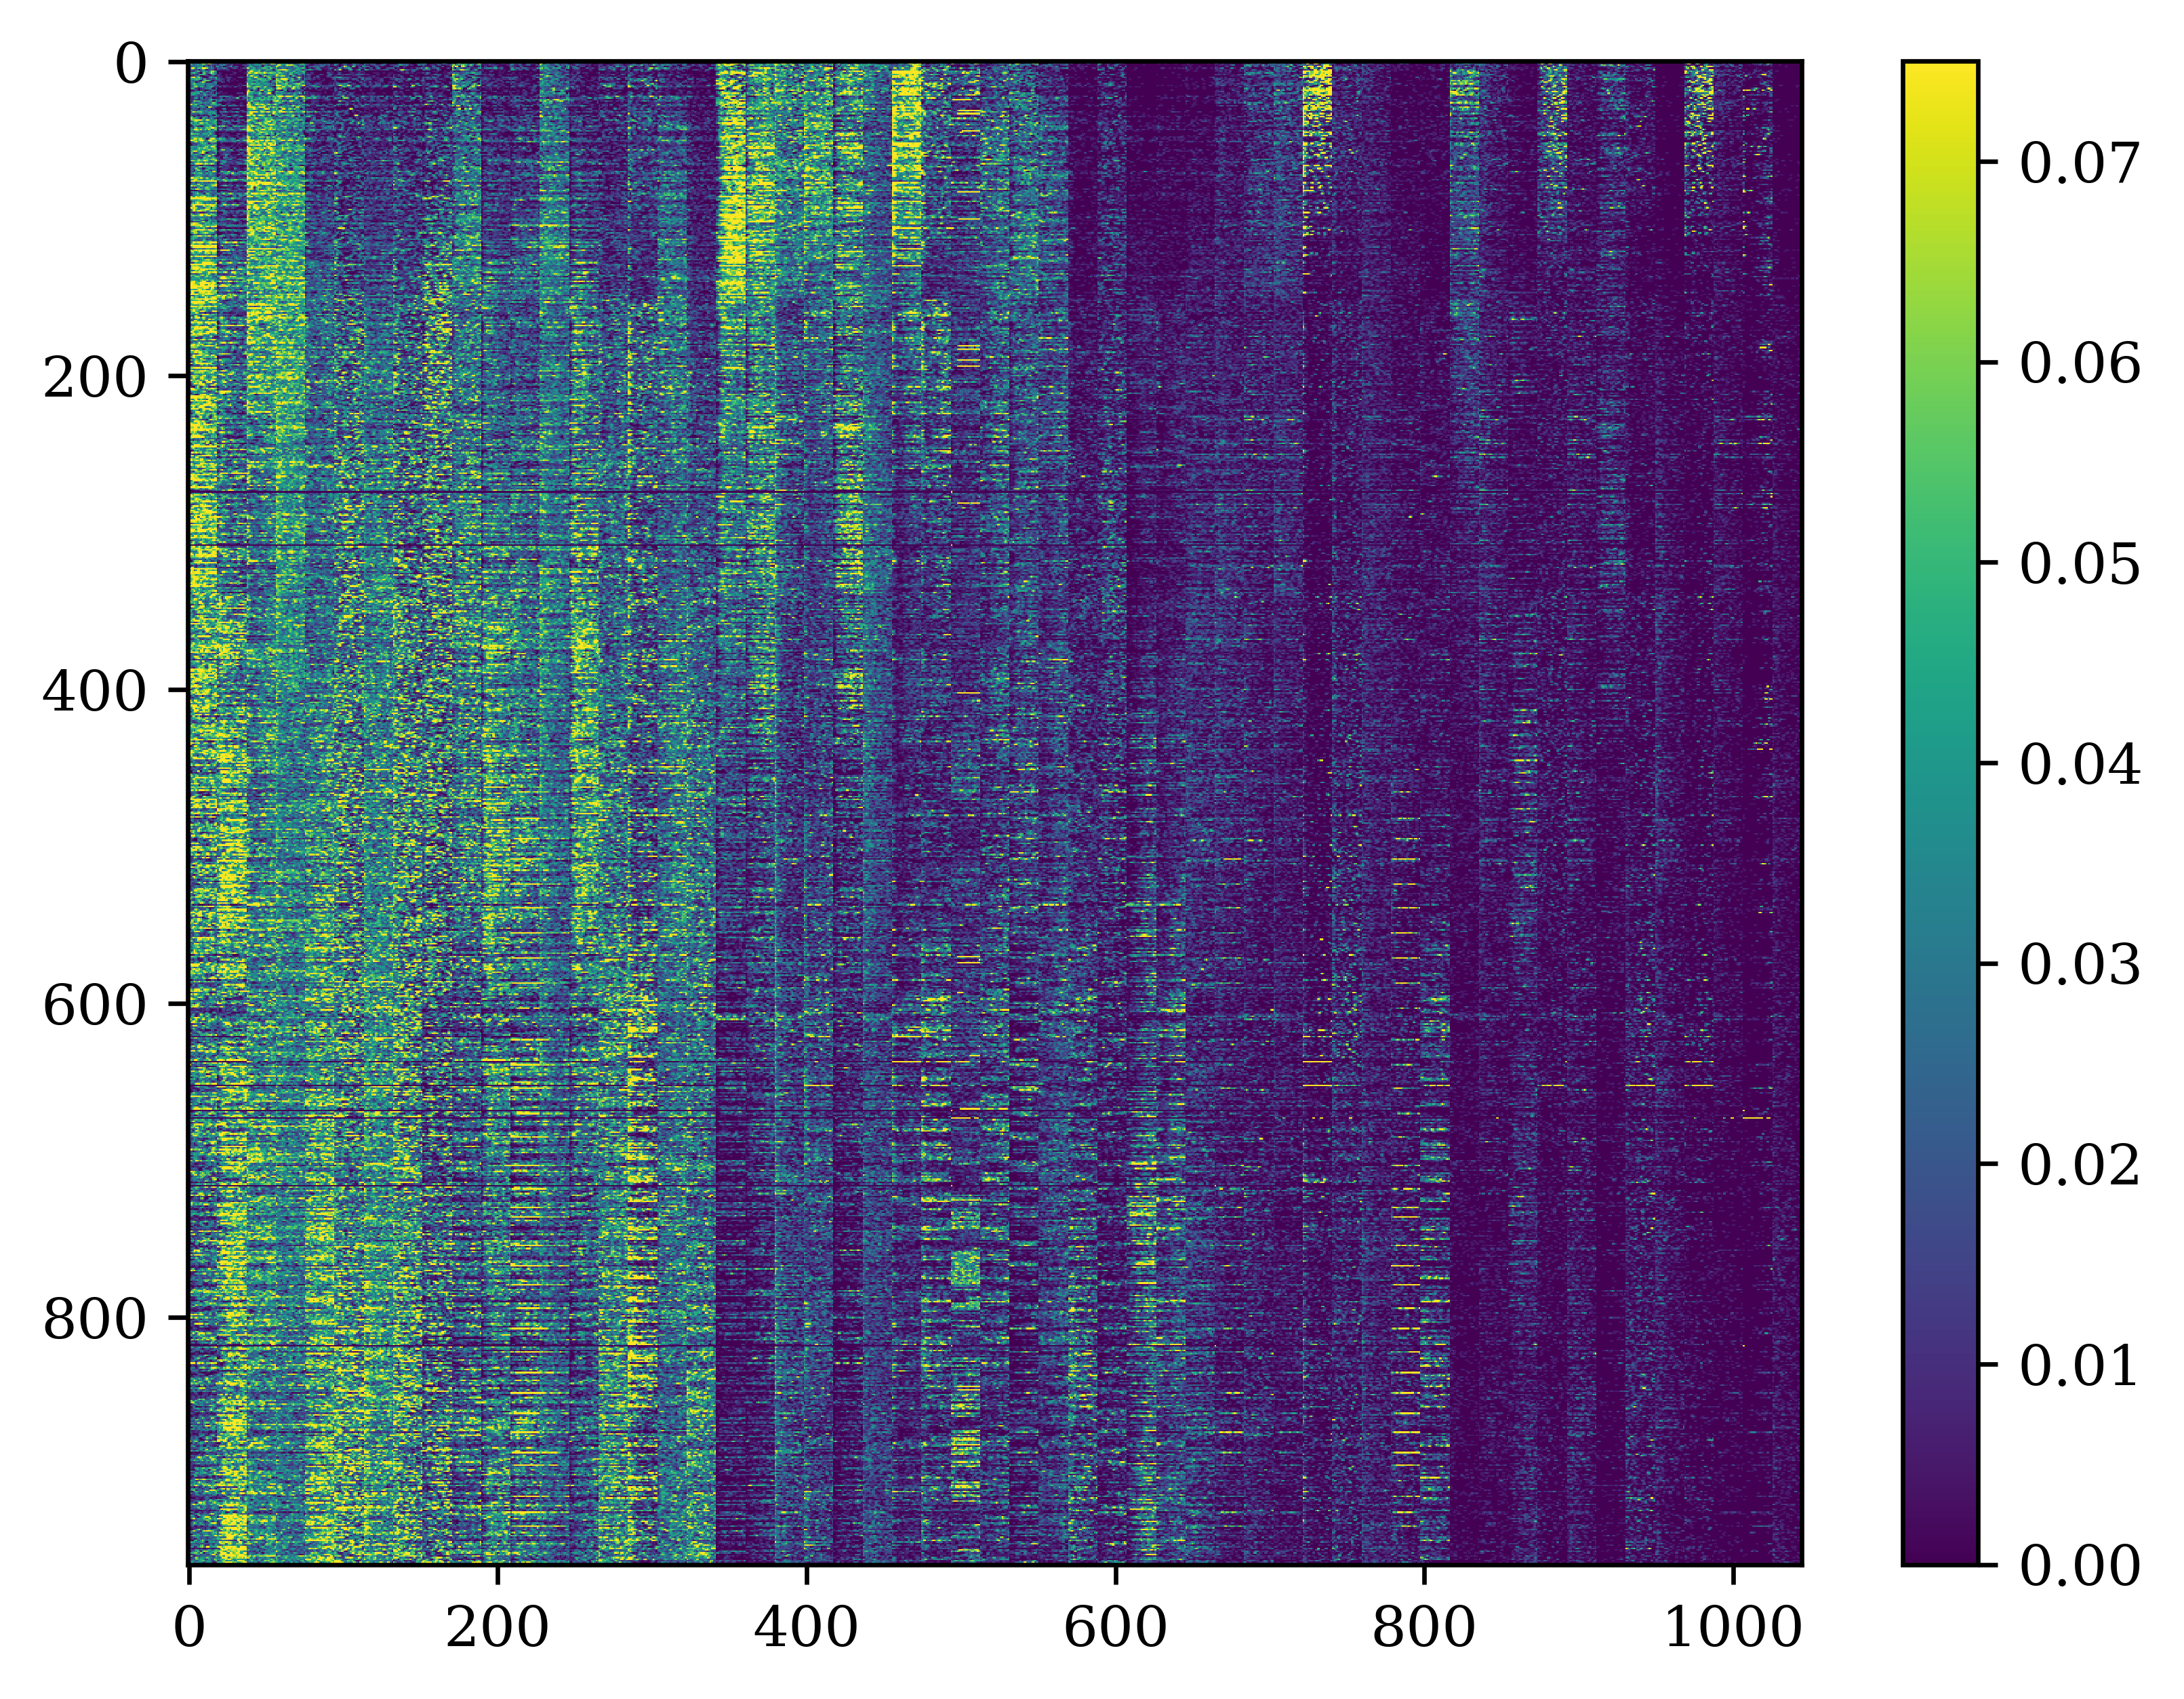

In [6]:
plt.imshow(df, aspect='auto', interpolation='none', vmax=0.075)
plt.colorbar()

In [22]:
pca = PCA()
pca.fit(df)

PCA()

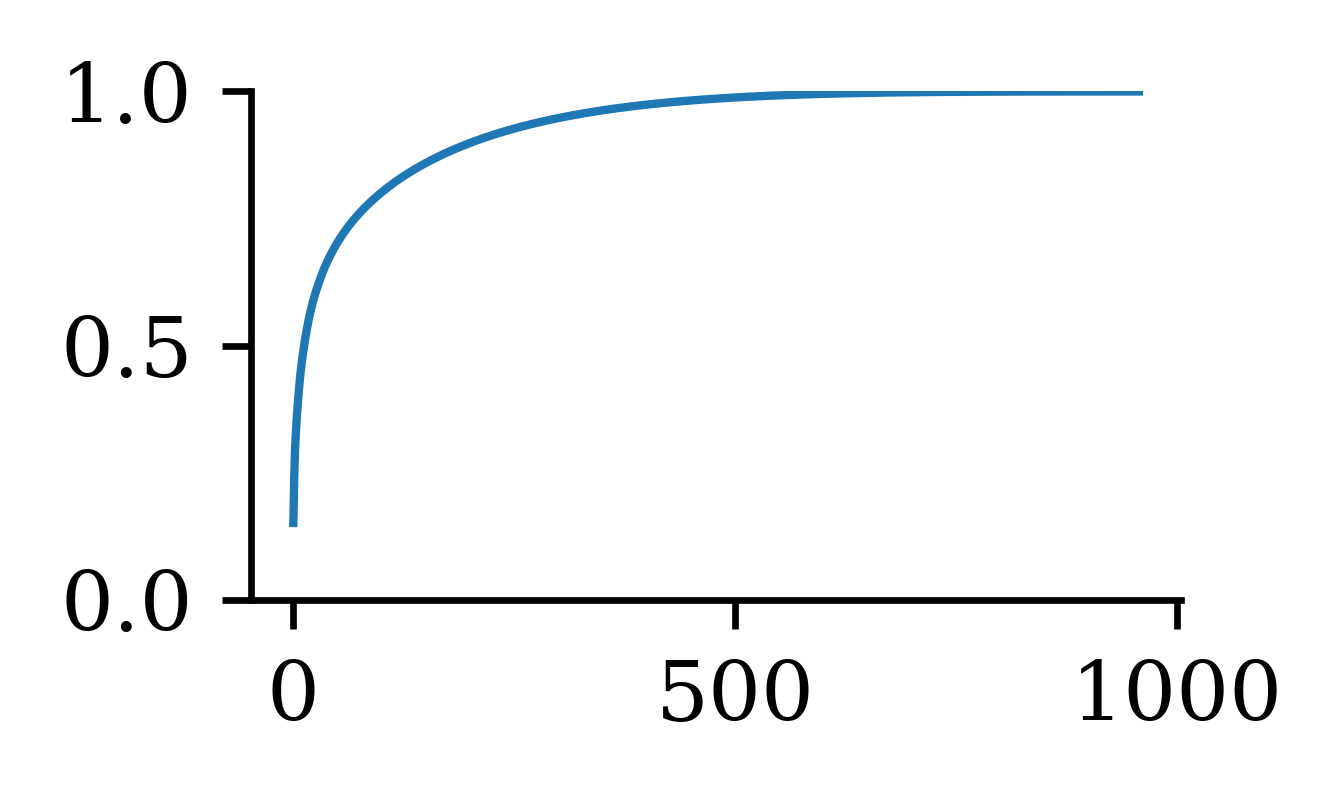

In [9]:
figure(2, 1.1)
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=1)
ax = plt.gca()
ax.set(ylim=(0, 1))
sns.despine()

In [10]:
np.cumsum(pca.explained_variance_ratio_)[:15]

array([0.15089513, 0.2424009 , 0.29886933, 0.332516  , 0.36167577,
       0.38486192, 0.40720123, 0.42610341, 0.44439652, 0.46005292,
       0.47411207, 0.48613057, 0.49773035, 0.50929514, 0.51962182])

In [11]:
pca.explained_variance_ratio_[:15]

array([0.15089513, 0.09150577, 0.05646843, 0.03364667, 0.02915977,
       0.02318616, 0.02233931, 0.01890218, 0.01829311, 0.0156564 ,
       0.01405915, 0.0120185 , 0.01159977, 0.01156479, 0.01032668])

In [25]:
(np.cumsum(pca.explained_variance_ratio_) < 0.9).sum()

202

In [17]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(df)

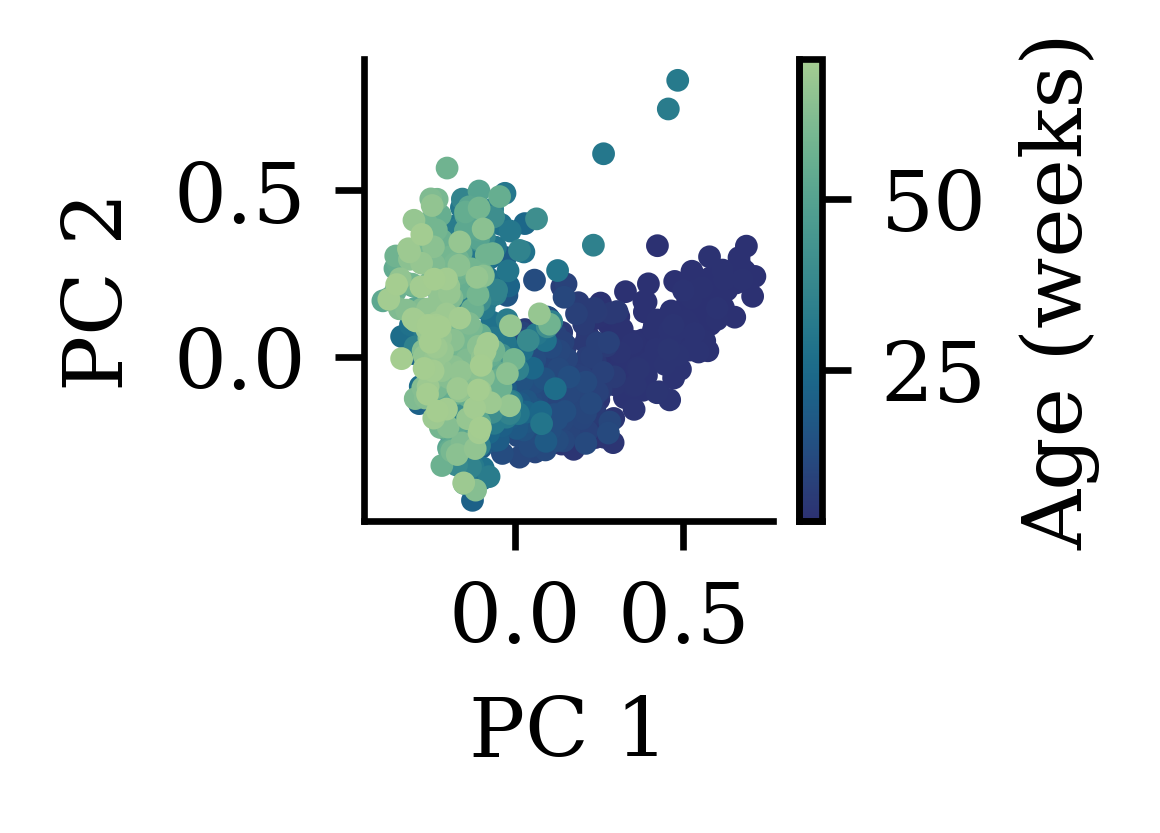

In [18]:
fig = figure(1.1, 1)
ax = fig.gca()
im = ax.scatter(*pcs[:, :2].T, c=df.index.get_level_values('age'), cmap='crest_r', s=3)
ax.set(xlabel='PC 1', ylabel='PC 2')
fig.colorbar(im, label='Age (weeks)')
sns.despine()
# saver(fig, 'pc1-vs-pc2');

In [19]:
pca.components_.shape

(2, 1045)

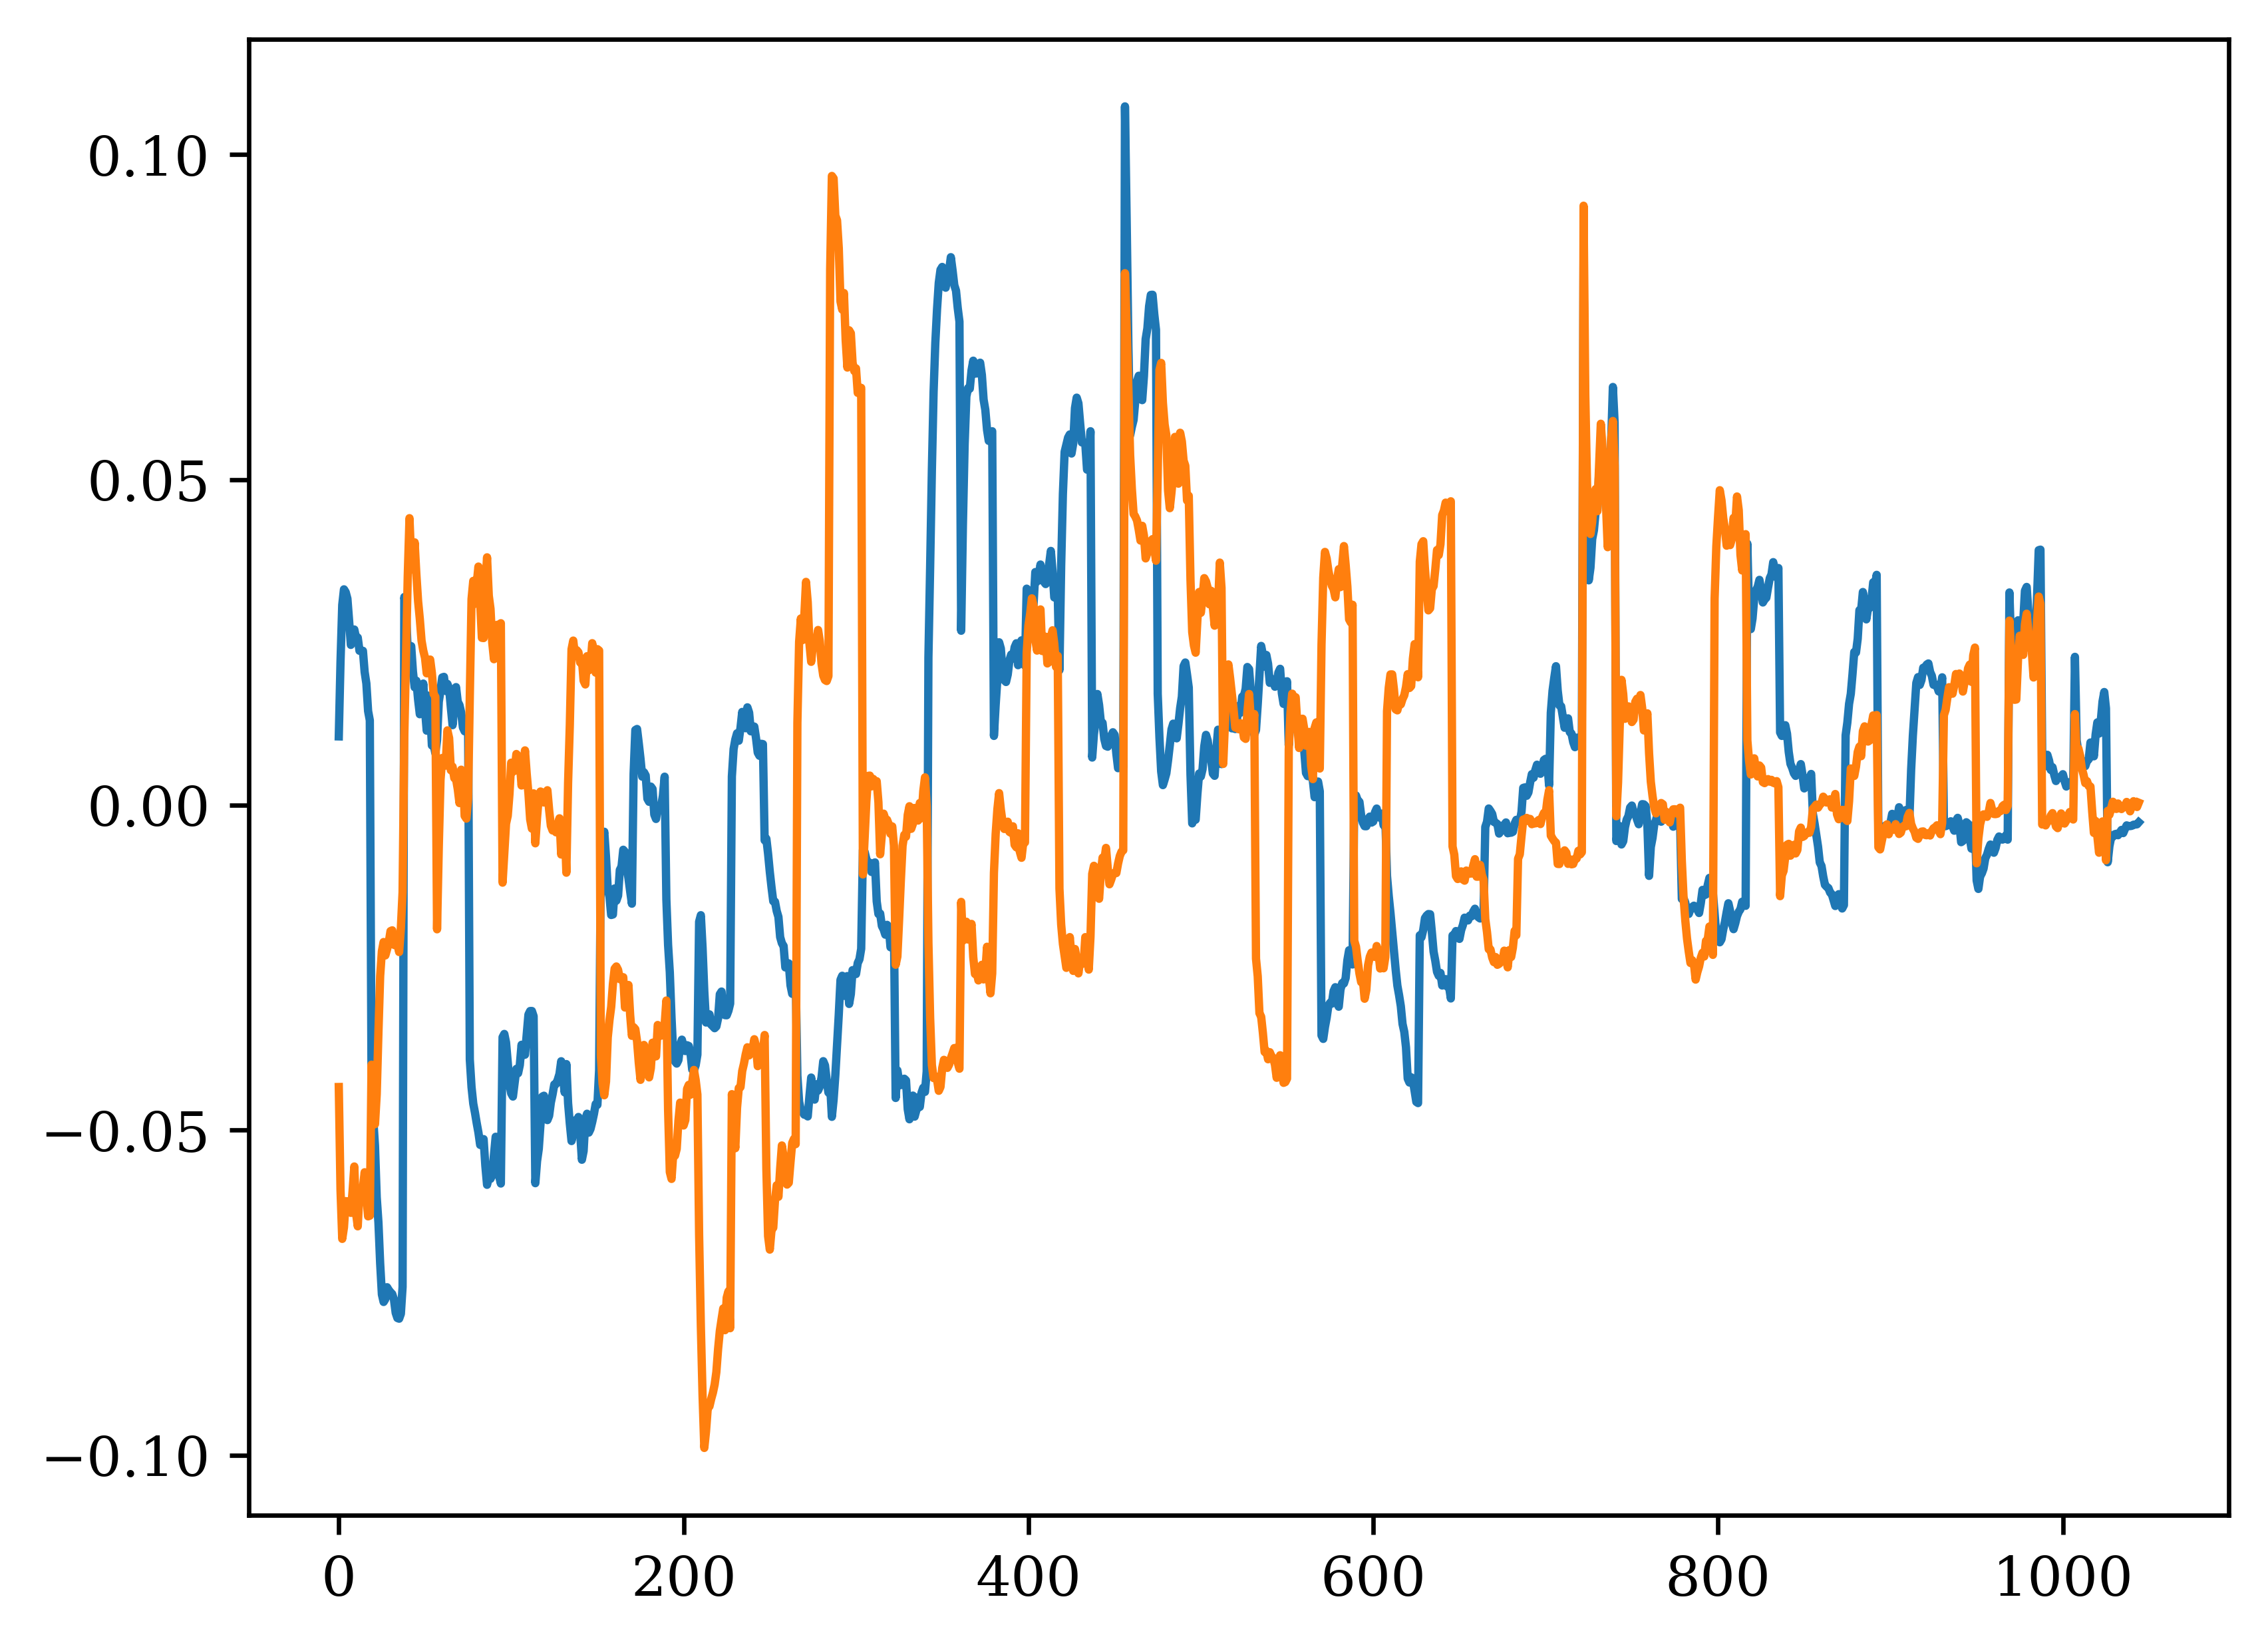

In [21]:
plt.plot(pca.components_[0])
plt.plot(pca.components_[1])